In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [4]:
import lovely_jax as lj
lj.monkey_patch()

ModuleNotFoundError: No module named 'lovely_jax'

In [6]:
import jax.numpy as jnp

In [7]:
import jax
from PIL import Image
import requests
from transformers import AutoProcessor, FlaxCLIPModel

In [8]:
model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

2024-07-19 06:09:04.194624: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


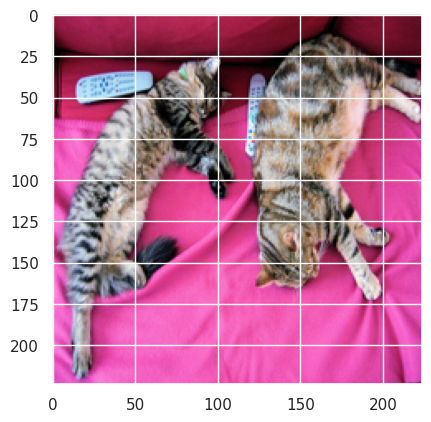

In [9]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_raw = Image.open(requests.get(url, stream=True).raw).resize((224, 224))
plt.imshow(image_raw)

# Default CLIP Demo

In [12]:
inputs = processor( text=["a photo of a lazy cat", "a photo of an active cat"], images=image_raw, return_tensors="np", padding=True)
print({k: v.shape for k, v in inputs.items()})
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = jax.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
print(probs)

{'input_ids': (2, 8), 'attention_mask': (2, 8), 'pixel_values': (1, 3, 224, 224)}
[[0.6150319  0.38496816]]


In [14]:
# print(jnp.array(inputs['pixel_values']))
print(jnp.array(inputs['pixel_values']).sum().item())

37822.921875


# Altered CLIP Demo

In [15]:
inputs = processor.tokenizer(text=["a photo of a lazy cat", "a photo of an active cat"], return_tensors="np", padding=True)
inputs['pixel_values'] = np.stack(processor.image_processor(image_raw, do_resize=False, do_center_crop=False, do_rescale=True)['pixel_values'])
print({k: v.shape for k, v in inputs.items()})
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = jax.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
print(probs)

{'input_ids': (2, 8), 'attention_mask': (2, 8), 'pixel_values': (1, 3, 224, 224)}
[[0.6150319  0.38496816]]


In [17]:
# print(jnp.array(inputs['pixel_values']))
print(jnp.array(inputs['pixel_values']).sum().item())

37822.921875


# My Demo

In [18]:
inputs = processor( text=["a photo of a lazy cat", "a photo of an active cat"], return_tensors="np", padding=True, )

# img = jnp.array(image_raw.resize((224, 224), resample=Image.BICUBIC))
img = jax.image.resize(jnp.array(image_raw), (224, 224, 3), 'bicubic')
mean, std = jnp.array(processor.image_processor.image_mean), jnp.array(processor.image_processor.image_std)
img = rearrange((img/255.-mean)/std, 'H W D -> 1 D H W')
inputs['pixel_values'] = img

In [19]:
print(jnp.array(inputs['pixel_values']))
print(jnp.array(inputs['pixel_values']).sum().item())

[[[[ 0.28071386  0.38290283  0.42669812 ... -0.2886247  -0.27402627
    -0.2886247 ]
   [ 0.32450914  0.38290283  0.4120997  ... -0.2886247  -0.2886247
    -0.31782156]
   [ 0.28071386  0.353706    0.3683044  ... -0.37621525 -0.3470184
    -0.31782156]
   ...
   [ 1.6383674   1.5361784   1.419391   ...  1.3901942   1.2880052
     1.2442099 ]
   [ 1.6091706   1.5507768   1.5069815  ...  1.215013    0.9814383
     0.8500524 ]
   [ 1.6091706   1.4777848   1.4923831  ...  0.12013119 -0.12804203
    -0.39081368]]

  [[-1.3919107  -1.3919107  -1.3919107  ... -1.5419884  -1.5419884
    -1.5569961 ]
   [-1.3468874  -1.3468874  -1.3468874  ... -1.5269806  -1.5119728
    -1.5269806 ]
   [-1.4069184  -1.3769029  -1.3468874  ... -1.5569961  -1.5419884
    -1.5419884 ]
   ...
   [-0.341367   -0.46142912 -0.5514757  ... -0.64152235 -0.7015534
    -0.7465767 ]
   [-0.341367   -0.3863903  -0.49144468 ... -0.73156893 -0.86663884
    -0.9266699 ]
   [-0.37138253 -0.49144468 -0.50645244 ... -1.2868563  -

In [20]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [21]:
z_text = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
z_img = model.get_image_features(inputs['pixel_values'])
z_text = z_text/jnp.linalg.norm(z_text, axis=-1, keepdims=True)
z_img = z_img/jnp.linalg.norm(z_img, axis=-1, keepdims=True)

In [22]:
z_img.shape, z_text.shape

((1, 512), (2, 512))

In [23]:
jax.nn.softmax((z_img@z_text.T)*jnp.exp(model.params['logit_scale']), axis=-1)

Array([[0.61469036, 0.3853096 ]], dtype=float32)

In [24]:
from clip_jax import MyFlaxCLIP

In [27]:
clip_model = MyFlaxCLIP("clip-vit-base-patch32")

/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [34]:
z_img = clip_model.embed_img(img/255.)
z_txt = clip_model.embed_text(["a photo of a lazy cat", "a photo of an active cat"])

In [48]:
jax.nn.softmax((z_txt@z_img)*100, axis=-1)

Array([0.61469036, 0.3853096 ], dtype=float32)

# Optimizing images with CLIP

In [19]:
def augment_image(_rng, img):
    H, W, D = img.shape
    assert H==W
    
    _rng1, _rng2 = split(_rng)
    crop_ratio = jax.random.uniform(_rng1, (2, ), minval=0.5, maxval=1.)
    crop_ratio = crop_ratio.at[1].set(crop_ratio[0])
    crop_loc = jax.random.uniform(_rng2, (2, ), minval=0., maxval=(1.-crop_ratio)*H)
    
    scale = 1./crop_ratio
    translation = -scale*crop_loc
    img = jax.image.scale_and_translate(img, (224, 224, 3), [0, 1], scale, translation, 'linear')
    return img

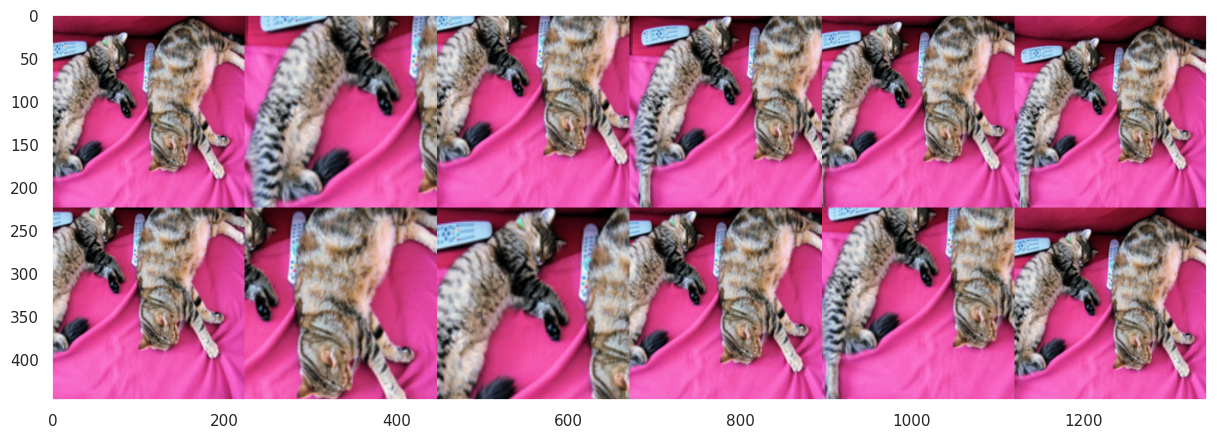

In [20]:
rng = jax.random.PRNGKey(0)
img = jnp.array(image_raw)/255.
a = jax.vmap(augment_image, in_axes=(0, None))(split(rng, 12), img)
plt.figure(figsize=(15, 5))
plt.imshow(rearrange(a, '(R C) H W D -> (R H) (C W) D', R=2))
plt.grid(False)

In [21]:
inputs = processor( text="a photo of a cat", return_tensors="np", padding=True, )
z_text = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
z_text = z_text/jnp.linalg.norm(z_text, axis=-1, keepdims=True)

In [22]:
z_text

Array[1, 512] 2Kb x∈[-0.122, 0.592] μ=0.002 σ=0.044 gpu:0

In [23]:
mean, std = jnp.array(processor.image_processor.image_mean), jnp.array(processor.image_processor.image_std)
print(mean, std)

img = jnp.full((224, 224, 3), fill_value=0.5)

Array[3] x∈[0.408, 0.481] μ=0.449 σ=0.031 gpu:0 [0.481, 0.458, 0.408] Array[3] x∈[0.261, 0.276] μ=0.269 σ=0.006 gpu:0 [0.269, 0.261, 0.276]


In [27]:
tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(1e-3))
train_state = TrainState.create(apply_fn=None, params=dict(img=img), tx=tx)

In [37]:
def loss_fn(params, _rng):
    img = params['img']

    img = augment_image(_rng, img)
    
    img = rearrange((img-mean)/std, 'H W D -> 1 D H W')
    z_img = model.get_image_features(img)
    z_img = z_img/jnp.linalg.norm(z_img, axis=-1, keepdims=True)
    loss = -(z_img@z_text.T).mean()
    return loss, None

@jax.jit
def train_step(train_state, _rng):
    # _rng1, _rng2 = split(_rng)
    # batch = dict(_rng=split(_rng1, args.bs), state=jax.vmap(init_state_fn)(split(_rng2, args.bs)))
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(train_state.params, _rng)
    # print(jax.tree.map(lambda x: x.shape, grads))
    loss = loss_fn(train_state.params, _rng)
    # print(loss)
    # train_state = train_state.apply_gradients(grads=grads)
    return train_state, loss

# loss_fn(train_state.params)

In [38]:
rng = jax.random.PRNGKey(0)
losses = []
for i in tqdm(range(100)):
    rng, _rng = split(rng)
    train_state, loss = train_step(train_state, _rng)
    losses.append(loss)
    # print(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
plt.plot(jnp.stack(losses))

TypeError: stack requires ndarray or scalar arguments, got <class 'tuple'> at position 0.

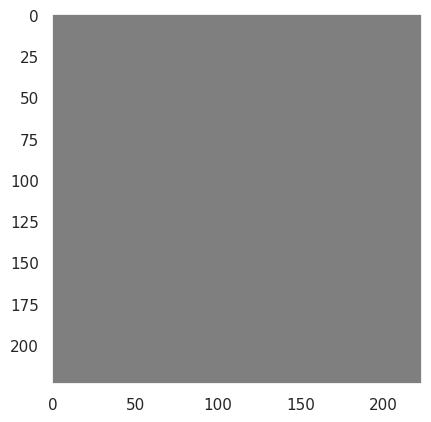

In [39]:
plt.imshow(train_state.params['img'].clip(0, 1))
plt.grid(False)

In [42]:
model.params['vision_model']

{'embeddings': {'class_embedding': Array[768] 3Kb x∈[-1.819, 1.545] μ=-0.006 σ=0.235 gpu:0,
  'patch_embedding': {'kernel': Array[32, 32, 3, 768] n=2359296 (9Mb) x∈[-0.185, 0.168] μ=7.765e-06 σ=0.015 gpu:0},
  'position_embedding': {'embedding': Array[50, 768] n=38400 (0.1Mb) x∈[-0.319, 0.337] μ=-0.012 σ=0.041 gpu:0}},
 'encoder': {'layers': {'0': {'layer_norm1': {'bias': Array[768] 3Kb x∈[-1.226, 2.083] μ=-0.008 σ=0.195 gpu:0,
     'scale': Array[768] 3Kb x∈[-0.000, 1.794] μ=0.662 σ=0.262 gpu:0},
    'layer_norm2': {'bias': Array[768] 3Kb x∈[-0.966, 0.831] μ=-0.011 σ=0.219 gpu:0,
     'scale': Array[768] 3Kb x∈[0.479, 4.510] μ=1.004 σ=0.400 gpu:0},
    'mlp': {'fc1': {'bias': Array[3072] 12Kb x∈[-1.475, 0.287] μ=-0.706 σ=0.441 gpu:0,
      'kernel': Array[768, 3072] n=2359296 (9Mb) x∈[-0.246, 0.304] μ=0.000 σ=0.015 gpu:0},
     'fc2': {'bias': Array[768] 3Kb x∈[-0.965, 0.410] μ=0.004 σ=0.101 gpu:0,
      'kernel': Array[3072, 768] n=2359296 (9Mb) x∈[-0.285, 0.221] μ=5.503e-05 σ=0.010 

In [7]:
import jax
from PIL import Image
from open_clip_jax import CLIPInference

2024-06-11 15:10:52.209755: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


ImportError: cannot import name 'Array' from 'flax.linen.dtypes' (/home/akarshkumar0101/.virtualenvs/nca-alife-clip/lib/python3.9/site-packages/flax/linen/dtypes.py)

In [76]:
rng = jax.random.PRNGKey(0)
A = jax.random.normal(rng, (32, 32, 16))
rng, _rng = split(rng)
b = jax.random.normal(rng, (16,))

In [82]:
jax.nn.softmax(jnp.array([0, .006*100])).tolist()[-1]

0.6456562876701355